<h1 align="center">Decision trees</h1> 

- **Решающие деревья** -- принцип работы.
- **Критерий информативности**: Entropy, Gini, MSE
- **Cчитаем entropy-mse на простом примере**
- **Дискретизация признаков** :)
- **Алгоритм** ID3, CART
- **Контест**
- **Детали реализации**
    - Прунинг
    - Feature importance
    - Не стабильность
    - Missing Values
    - Как эффективно прогать
- **Tree Visualization** (Graphviz)


In [12]:
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
from IPython.core.display import Image, display

%pylab inline
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Решающие деревья -- принцип работы

-------

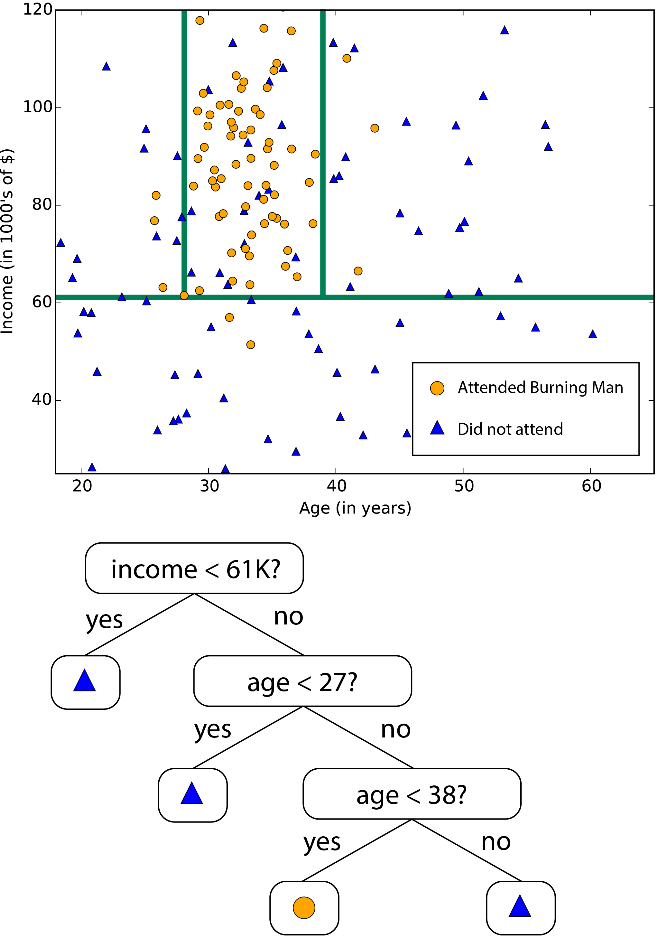

In [13]:
Image('pics/image5.png')

In [14]:
data = pd.read_csv('data/adult.csv', header=0, sep=', ', engine='python')

Adult dataset: https://archive.ics.uci.edu/ml/datasets/Adult

In [15]:
data.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country salary  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

### **Критерий информативности**: Entropy, Gini, MSE
### Entropy

### $$ H(p)=-\sum_{i=1}^np(i)\log_2 p(i) $$

In [16]:
sex = data.sex.value_counts(normalize=True)
print 'Sex counts: \n', sex

Sex counts: 
Male      0.669205
Female    0.330795
Name: sex, dtype: float64


In [17]:
sex = sex.to_dict()
sex

{'Female': 0.33079450876815825, 'Male': 0.66920549123184181}

In [18]:
from scipy.stats import entropy

In [19]:
# implement entropy function
entropy2 = lambda x: np.sum( -np.multiply(x, np.log2(x)) )

In [20]:
try: 
    assert entropy(sex.values(), base=2) - entropy2(sex.values()) < 0.001
    print 'Enropy function implementation is valid (-: '
except: 
    print 'Enropy function implementation is invalid'

Enropy function implementation is valid (-: 


---------
### Gini

<img src="pics/Economics_Gini_coefficient2.svg", height="400" width="400">

### $$ G=\frac {\sum_{i=1}^n \sum_{j=1}^n\left\vert y_i - y_j \right\vert }{ 2 n^2 \bar{y}} $$

In [55]:
Image('gini.png', width=800)

In [21]:
from pysal.inequality.gini import Gini

In [22]:
# implement gini function
gini = lambda x: (x*(1-x)).sum()

In [23]:
try: 
    assert Gini(np.array(sex.values())).g - gini(np.array(sex.values())) < 0.001
    print 'Gini function implementation is valid (-: '
except: 
    print 'Gini function implementation is invalid'

Gini function implementation is valid (-: 


### MSE

- Если предсказываем цифру -- нужно смнимизировать что-то для цифр
- Если фича непрерывная -- отсечку выбираем сами

$$MSE = \sum_i (y_i - c_{feature})^2$$

--------
### Class Work
### $$entropy(p) = - \sum_i p_i~ln~p_i$$

In [58]:
np.log(1)

0.0

In [59]:
sc.stats.entropy([0.5, 0.5])

0.69314718055994529

In [60]:
sc.stats.entropy([0.1, 0.9])

0.3250829733914482

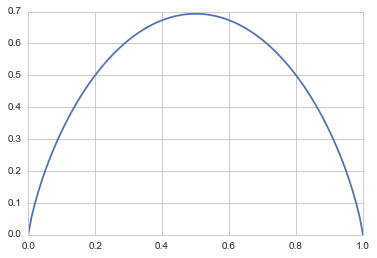

In [61]:
x = np.linspace(0, 1, 100)
y = map(lambda p: sc.stats.entropy([p, 1-p]), x)
pylab.plot(x, y)

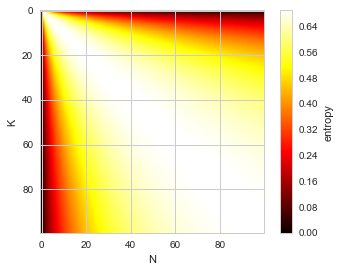

In [62]:
# Attantion, Bad code!!! 
im = np.zeros((100, 100))

for i in range(1, 100):
    for j in range(1, 100):
        p = [i , j]
        im[i, j] = sc.stats.entropy(p)
    
img = pylab.imshow(im, cmap='hot')
pylab.xlabel('N')
pylab.ylabel('K')
cb = pylab.colorbar(img)
cb.ax.set_ylabel('entropy')

In [63]:
sc.stats.entropy([0.1, 0.1, 0.8])

0.63903185965017695

In [64]:
sc.stats.entropy([0.1, 0.2, 0.7])

0.80181855254333734

In [65]:
N, K, P = 100, 100, 50
n, k, p = 10, 1, 1
print sc.stats.entropy([10.0/250, 1.0/250, 1.0/250])
print sc.stats.entropy([10.0/12, 1.0/12, 1.0/12])

0.56608573896
0.56608573896


---------
### Дискретизация признаков
https://github.com/UIUC-data-mining/mdlp-discretization

In [3]:
from discretization import MDLP
from sklearn.datasets import load_iris

In [4]:
iris = load_iris()
X = iris.data
y = iris.target

In [6]:
plt.hist(X[:, 3])
print 'Iris, feature 1 histogram'

In [ ]:
mdlp = MDLP()
conv_X = mdlp.fit_transform(X, y)

In [ ]:
conv_X[:, 1]

--------
### ID3 Summary

1. Calculate the entropy of every attribute using the data set S
2. Split the set S into subsets using the attribute for which entropy is minimum (or, equivalently, information gain is maximum)
3. Make a decision tree node containing that attribute
4. Recurse on subsets using remaining attributes.

ID3 vs CART

Tests in CART are always binary, but ID3/C4.5 allows two or more outcomes.
1. CART uses the Gini diversity index to rank tests, whereas ID3/C4.5 uses information-based
criteria.
2. CART prunes trees using a cost-complexity model whose parameters are estimated by
cross-validation; ID3/C4.5 uses a single-pass algorithm derived from binomial confidence
limits.

Greate visualization: http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

-----------
### Контест

In [66]:
df = pd.read_table('./contest/contest.csv', sep='\t')

In [67]:
df

Day    Outlook Temperature Humidity    Wind PlayBaseball
0    D1     Sunny          Hot    High     Weak           No
1    D2     Sunny          Hot    High   Strong           No
2    D3  Overcast          Hot    High     Weak          Yes
3    D4      Rain         Mild    High     Weak          Yes
4    D5      Rain         Cool  Normal     Weak          Yes
5    D6      Rain         Cool  Normal   Strong           No
6    D7  Overcast         Cool  Normal   Strong          Yes
7    D8     Sunny         Mild    High     Weak           No
8    D9     Sunny         Cool  Normal     Weak          Yes
9   D10      Rain         Mild  Normal     Weak          Yes
10  D11     Sunny         Mild  Normal   Strong          Yes
11  D12  Overcast         Mild    High   Strong          Yes
12  D13  Overcast          Hot  Normal     Weak          Yes
13  D14      Rain         Mild    High   Strong           No

In [73]:
print df.groupby('PlayBaseball')['PlayBaseball'].count()

PlayBaseball
No     5
Yes    9
Name: PlayBaseball, dtype: int64


In [69]:
df.groupby(['Outlook', 'PlayBaseball'])['PlayBaseball'].count().to_frame()

PlayBaseball
Outlook   PlayBaseball              
Overcast  Yes                      4
Rain      No                       2
          Yes                      3
Sunny     No                       3
          Yes                      2

In [70]:
df.groupby(['Temperature', 'PlayBaseball'])['PlayBaseball'].count().to_frame()

PlayBaseball
Temperature PlayBaseball              
Cool        No                       1
            Yes                      3
Hot         No                       2
            Yes                      2
Mild        No                       2
            Yes                      4

In [71]:
df.groupby(['Wind', 'PlayBaseball'])['PlayBaseball'].count().to_frame()

PlayBaseball
Wind   PlayBaseball              
Strong No                       3
       Yes                      3
Weak   No                       2
       Yes                      6

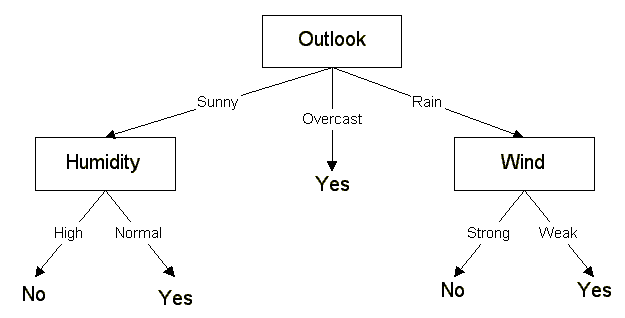

In [74]:
# Ansswer 
Image('./contest/tree.png')

--------
### Prooning

- Уменьшение дерева (объединение поддеревьев)
- Ограничение высосты, ограничение на листы <- часто используемый 

In [75]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = skl.preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_data, encoders = number_encode_features(data)
encoded_data.head()

age  workclass  fnlwgt  education  education-num  marital-status  \
0   39          7   77516          9             13               4   
1   50          6   83311          9             13               2   
2   38          4  215646         11              9               0   
3   53          4  234721          1              7               2   
4   28          4  338409          9             13               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           1             1     4    1          2174             0   
1           4             0     4    1             0             0   
2           6             1     4    1             0             0   
3           6             0     2    1             0             0   
4          10             5     2    0             0             0   

   hours-per-week  native-country  salary  
0              40              39       0  
1              13              39       0  
2              40              39       0  
3              40              39       0  
4              40               5       0

In [ ]:
tree = skl.tree.DecisionTreeClassifier(min_samples_split=1, min_samples_leaf=1)
tree = tree.fit(X_train, y_train)
print 'train score = ', skl.metrics.accuracy_score(y_train, tree.predict(X_train))
print 'test  score = ', skl.metrics.accuracy_score(y_test, tree.predict(X_test))

In [ ]:
tree = skl.tree.DecisionTreeClassifier(min_samples_leaf=30, max_depth=9)
tree = tree.fit(X_train, y_train)
print 'train score = ', skl.metrics.accuracy_score(y_train, tree.predict(X_train))
print 'test  score = ', skl.metrics.accuracy_score(y_test, tree.predict(X_test))

### Impotance 

Чем выше вершина в дереве, тем:
- нижее энтропия при разбиении по предикату из вершины
- вершина примит участие в решении для больших обектов
- ошибка в ней критична

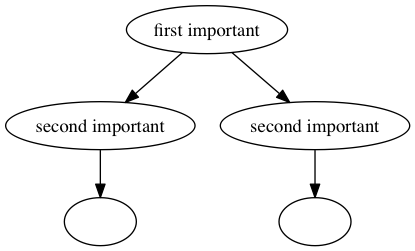

In [77]:
Image('pics/importance.png')

### Unstability
- Жадная стратегия выбара блоков -> ошибаемся -> Переподвешивание

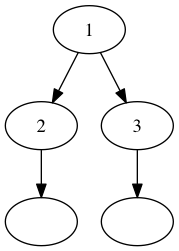

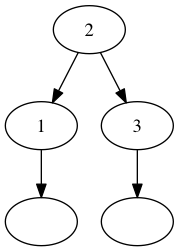

In [78]:
display(Image('pics/rew1.png'), Image('pics/rew2.png'))

### Missing Values

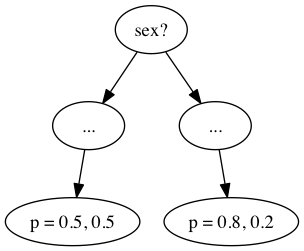

In [79]:
Image('pics/missing_value.png')

### How to code

- Мы не меняем матрицу объектов -> храним только индексы
- Запросы выполнять через numpy X[idx]... !!! Pandas часто копирует данные !! 
- Независимые ветви можно строить парралельно *= n память

### Tree Visualization (Graphviz)

In [80]:
# http://www.graphviz.org/About.php

In [81]:
value = """strict digraph G {
1 [label="hi\\nhi", shape="box"];
2;
3[label="hi\\nhi"];
4;
5;
1 -> 2;
1 -> 3;
1 -> 5  [weight="0.5", color="red"];
2 -> 4;
}
"""

open('tree.dot', 'w').write(value)

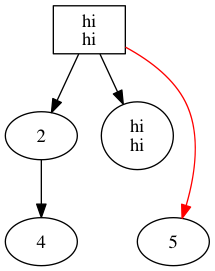

In [82]:
!dot -Tpng tree.dot -o tree.png
Image('tree.png')

In [83]:
import sklearn
tree = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=30, max_depth=3)
tree = tree.fit(X_train, y_train)
sklearn.tree.export_graphviz(tree, 'tree.dot', feature_names=encoded_data.columns[:-2], class_names=['high50k', 'less50k'])

AttributeError: 'module' object has no attribute 'tree'

In [ ]:
!dot -Tpng tree.dot -o tree.png
Image('tree.png')